In [1]:
from robustbench.data import load_cifar10
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchattacks

In [2]:
# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First conv block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x, gradient_routing = False, return_routed_act=False):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second conv block
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        act = self.pool2(x)

        if gradient_routing:
            mask = torch.zeros_like(act)
            mask[:, :64, ...] = 1 # half of values become 1
            x = mask * act + (1 - mask) * act.detach() # from https://arxiv.org/pdf/2410.04332
        else:
            x = act

        routed_activation = x.clone().detach()
        
        # Third conv block
        x = self.relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten and fully connected
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
            
        if return_routed_act:
            return x, routed_activation
        return x

# Data loading and preprocessing
def load_cifar10():
    # Simple data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
    ])
    
    # No augmentation for test
    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Load datasets
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2
    )
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=128, shuffle=False, num_workers=2
    )
    return trainloader, testloader

In [7]:
trainloader, testloader = load_cifar10()

In [164]:
model = SimpleCNN(num_classes=10)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 2,638,794


In [165]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=24/255, alpha=2/255, steps=100)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1.5, kappa=0, steps=200)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)


def get_targeted_attack_imgs(clean_imgs, clean_labels):
    # get random labels for targeted attack!
    adv_targets = torch.randint(0, 9, clean_labels.shape, device=device)
    adv_targets = torch.where(adv_targets >= clean_labels, adv_targets + 1, adv_targets)

    # print(clean_imgs.shape)
    adv_images = pgd(clean_imgs, adv_targets)
    
    with torch.no_grad():
        outputs = model(adv_images.to(device))
        _, predicted = torch.max(outputs, 1)
    
    success_rate = (predicted == adv_targets).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')

    succ_adv_imgs = adv_images[predicted == adv_targets]
    adv_targets = adv_targets[predicted == adv_targets]
    print(f'{len(succ_adv_imgs)} successful adversarial imgs')
    return succ_adv_imgs, adv_targets

# Training function
def train_model(model, trainloader, num_epochs=10):
    device = 'mps'
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    
    print(f"Training on {device}")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            succ_adv_imgs, adv_targets = get_targeted_attack_imgs(inputs, targets)

            optimizer.zero_grad()
            
            outputs, routed_act_clean = model(inputs, return_routed_act=True)
            adv_outputs, routed_act_dirty = model(succ_adv_imgs, gradient_routing=True, return_routed_act=True)

            # mask = torch.zeros_like(routed_act_dirty)
            # mask[:, :64, ...] = 1
            print("clean norm", torch.sum(torch.abs(routed_act_clean[:, :64, ...])))
            print("dirty norm", torch.sum(torch.abs(routed_act_dirty[:, :64, ...])))
  
            loss = criterion(outputs, targets) + criterion(adv_outputs, adv_targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1} completed: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

In [166]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=10)


Starting training...
Training on mps
Attack success rate: 10.16%
13 successful adversarial imgs
clean norm tensor(9734.5000, device='mps:0')
dirty norm tensor(1014.7092, device='mps:0')
Epoch: 1/10, Batch: 0, Loss: 4.5649, Acc: 7.03%
Attack success rate: 10.16%
13 successful adversarial imgs
clean norm tensor(16812.4688, device='mps:0')
dirty norm tensor(2008.4172, device='mps:0')
Attack success rate: 10.94%
14 successful adversarial imgs
clean norm tensor(43608.6875, device='mps:0')
dirty norm tensor(5645.2793, device='mps:0')
Attack success rate: 14.06%
18 successful adversarial imgs
clean norm tensor(66827.6562, device='mps:0')
dirty norm tensor(11073.1719, device='mps:0')
Attack success rate: 8.59%
11 successful adversarial imgs
clean norm tensor(35582.1094, device='mps:0')
dirty norm tensor(3480.0527, device='mps:0')
Attack success rate: 11.72%
15 successful adversarial imgs
clean norm tensor(21806.2617, device='mps:0')
dirty norm tensor(3003.1985, device='mps:0')
Attack success 

In [157]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=10)


Starting training...
Training on mps
Attack success rate: 8.59%
11 successful adversarial imgs
clean norm tensor(6811.0078, device='mps:0')
dirty norm tensor(615.4380, device='mps:0')
Epoch: 1/10, Batch: 0, Loss: 4.5583, Acc: 10.94%
Attack success rate: 7.81%
10 successful adversarial imgs
clean norm tensor(10040.6895, device='mps:0')
dirty norm tensor(877.0325, device='mps:0')
Attack success rate: 8.59%
11 successful adversarial imgs
clean norm tensor(22744.7188, device='mps:0')
dirty norm tensor(2158.6272, device='mps:0')
Attack success rate: 10.94%
14 successful adversarial imgs
clean norm tensor(50696.3203, device='mps:0')
dirty norm tensor(5955.9912, device='mps:0')
Attack success rate: 9.38%
12 successful adversarial imgs
clean norm tensor(29346.8867, device='mps:0')
dirty norm tensor(3233.3669, device='mps:0')
Attack success rate: 7.81%
10 successful adversarial imgs
clean norm tensor(19587.2266, device='mps:0')
dirty norm tensor(1639.0381, device='mps:0')
Attack success rate: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x107d4c720>
Traceback (most recent call last):
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/connection

KeyboardInterrupt: 

In [9]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=5)


Starting training...
Training on mps
Epoch: 1/5, Batch: 0, Loss: 2.3026, Acc: 12.50%
Epoch: 1/5, Batch: 100, Loss: 1.9068, Acc: 22.89%
Epoch: 1/5, Batch: 200, Loss: 1.5944, Acc: 28.66%
Epoch: 1/5, Batch: 300, Loss: 1.4324, Acc: 33.14%
Epoch 1 completed: Loss: 1.7081, Accuracy: 36.44%
Epoch: 2/5, Batch: 0, Loss: 1.4737, Acc: 41.41%
Epoch: 2/5, Batch: 100, Loss: 1.2099, Acc: 52.02%
Epoch: 2/5, Batch: 200, Loss: 1.0808, Acc: 53.33%
Epoch: 2/5, Batch: 300, Loss: 1.1116, Acc: 54.79%
Epoch 2 completed: Loss: 1.2104, Accuracy: 56.05%
Epoch: 3/5, Batch: 0, Loss: 0.9632, Acc: 65.62%
Epoch: 3/5, Batch: 100, Loss: 1.0346, Acc: 62.96%
Epoch: 3/5, Batch: 200, Loss: 0.9848, Acc: 63.93%
Epoch: 3/5, Batch: 300, Loss: 0.7750, Acc: 64.62%
Epoch 3 completed: Loss: 0.9768, Accuracy: 65.13%
Epoch: 4/5, Batch: 0, Loss: 0.8693, Acc: 68.75%
Epoch: 4/5, Batch: 100, Loss: 0.8879, Acc: 67.86%
Epoch: 4/5, Batch: 200, Loss: 0.9032, Acc: 68.98%
Epoch: 4/5, Batch: 300, Loss: 0.6599, Acc: 69.16%
Epoch 4 completed: L

In [167]:
import os

filepath='base_routed_model.pth'

os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)

# Save the model state dict
torch.save(model.state_dict(), filepath)
print(f"Model saved to {filepath}")

Model saved to base_routed_model.pth


In [11]:
# First, recreate the model instance
model = SimpleCNN(num_classes=10)  # Make sure num_classes matches what you used when saving

# Load the saved state dictionary
filepath = 'base_routed_model.pth'
model.load_state_dict(torch.load(filepath))
model = model.to('mps')

# Set the model to evaluation mode (important for inference)
model.eval()

print(f"Model loaded from {filepath}")

Model loaded from base_routed_model.pth


In [8]:
# Evaluation function
def evaluate_model(model, testloader):
    device = 'mps'
    model.eval()
    
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Per-class accuracy
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    overall_acc = 100 * correct / total
    print(f'\nOverall Test Accuracy: {overall_acc:.2f}%')
    
    print('\nPer-class accuracies:')
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {acc:.2f}%')
    
    return overall_acc

In [9]:
# Visualization function
def show_sample_predictions(model, testloader, num_samples=8):
    device = 'mps'
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Denormalize for visualization
    # mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    # std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        plt.subplot(2, 4, i + 1)
        
        # Denormalize image
        img = images[i].cpu() # * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)
        
        plt.imshow(img)
        color = 'green' if predicted[i] == labels[i] else 'red'
        plt.title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}', 
                 color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Evaluating model...

Overall Test Accuracy: 72.83%

Per-class accuracies:
plane: 78.70%
car: 86.20%
bird: 60.60%
cat: 54.10%
deer: 64.50%
dog: 71.20%
frog: 70.20%
horse: 78.90%
ship: 84.50%
truck: 79.40%


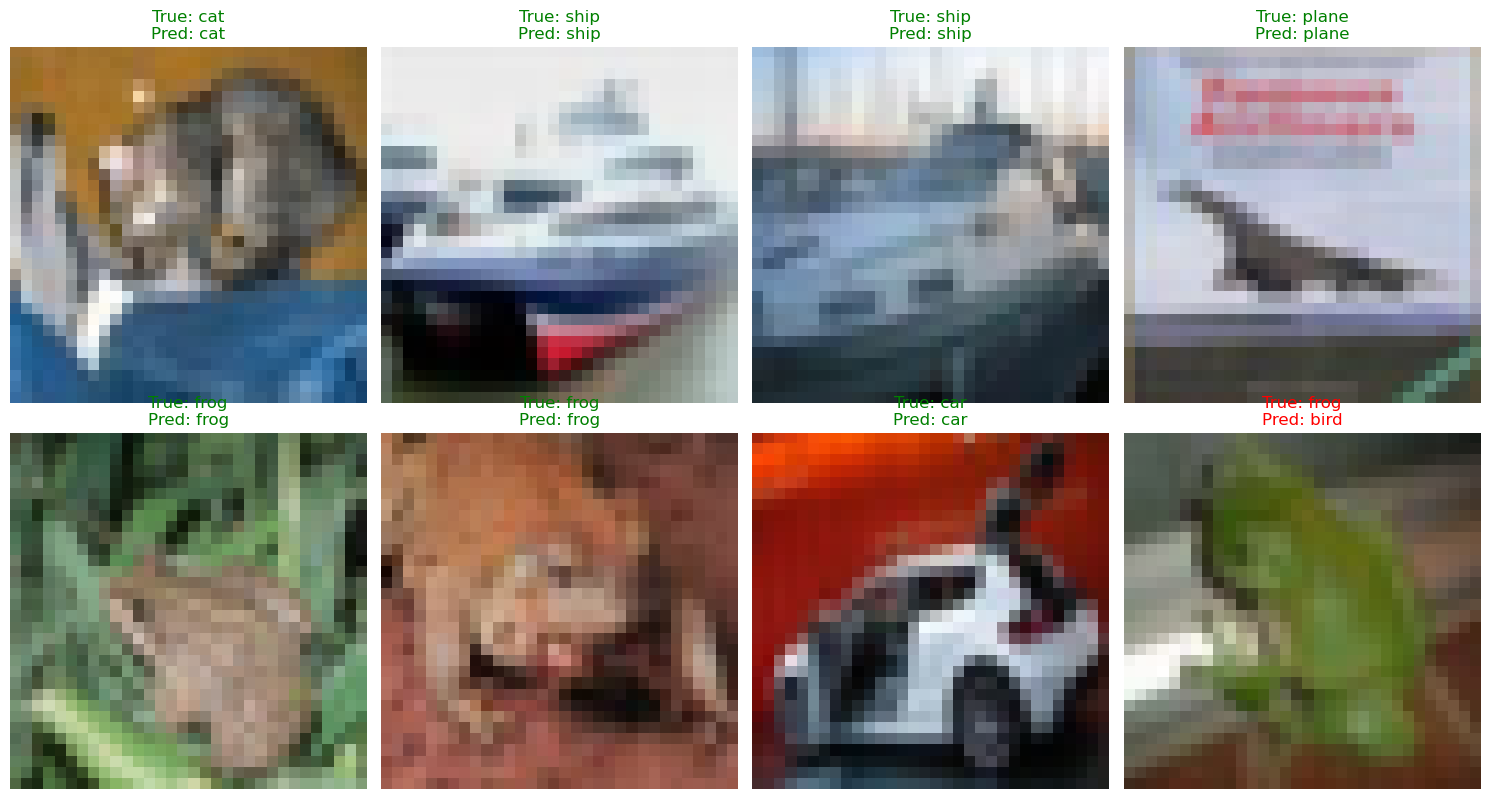

In [12]:
# Evaluate model
print("\nEvaluating model...")
test_accuracy = evaluate_model(model, testloader)

# Show sample predictions
show_sample_predictions(model, testloader)

In [19]:
clean_latents_dict = dict()
device = 'mps'
with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, clean_latents = model(inputs, return_routed_act=True)
        clean_layents = clean_latents.cpu()
        for latent, target in zip(clean_latents, targets):
            clean_latents_dict[int(target)] =  clean_latents_dict.get(int(target), []) + [latent]
        print(len(clean_latents_dict[0]))

13
26
44
57
68
76
92
108
122
134
142
150
160
179
190
198
216
229
244
254
270
281
289
305
319
330
344
358
369
378
387
397
416
429
446
457
464
478
488
500
515
534
545
557
567
580
591
607
619
636
650
668
680
695
709
724
734
741
755
764
782
802
817
824
831
841
853
860
872
886
905
917
926
934
953
966
980
998
1000


In [21]:
clean_latents_dict.keys()

dict_keys([3, 8, 0, 6, 1, 9, 5, 7, 4, 2])

In [22]:
len(clean_latents_dict[0][0])

128

In [23]:
clean_latents_dict[0][0].shape

torch.Size([128, 8, 8])

In [24]:
torch.mean(clean_latents_dict[0][0][64:])

tensor(0.0602, device='mps:0')

In [25]:
torch.mean(clean_latents_dict[0][0][:64])

tensor(0.1713, device='mps:0')

Data shape for PCA: (1280000, 64)
Number of samples per class:
  Class 0 (airplane): 128000 samples
  Class 1 (automobile): 128000 samples
  Class 2 (bird): 128000 samples
  Class 3 (cat): 128000 samples
  Class 4 (deer): 128000 samples
  Class 5 (dog): 128000 samples
  Class 6 (frog): 128000 samples
  Class 7 (horse): 128000 samples
  Class 8 (ship): 128000 samples
  Class 9 (truck): 128000 samples

PCA Results:
Explained variance ratio: [0.6389666  0.05613467]
Total explained variance: 0.695


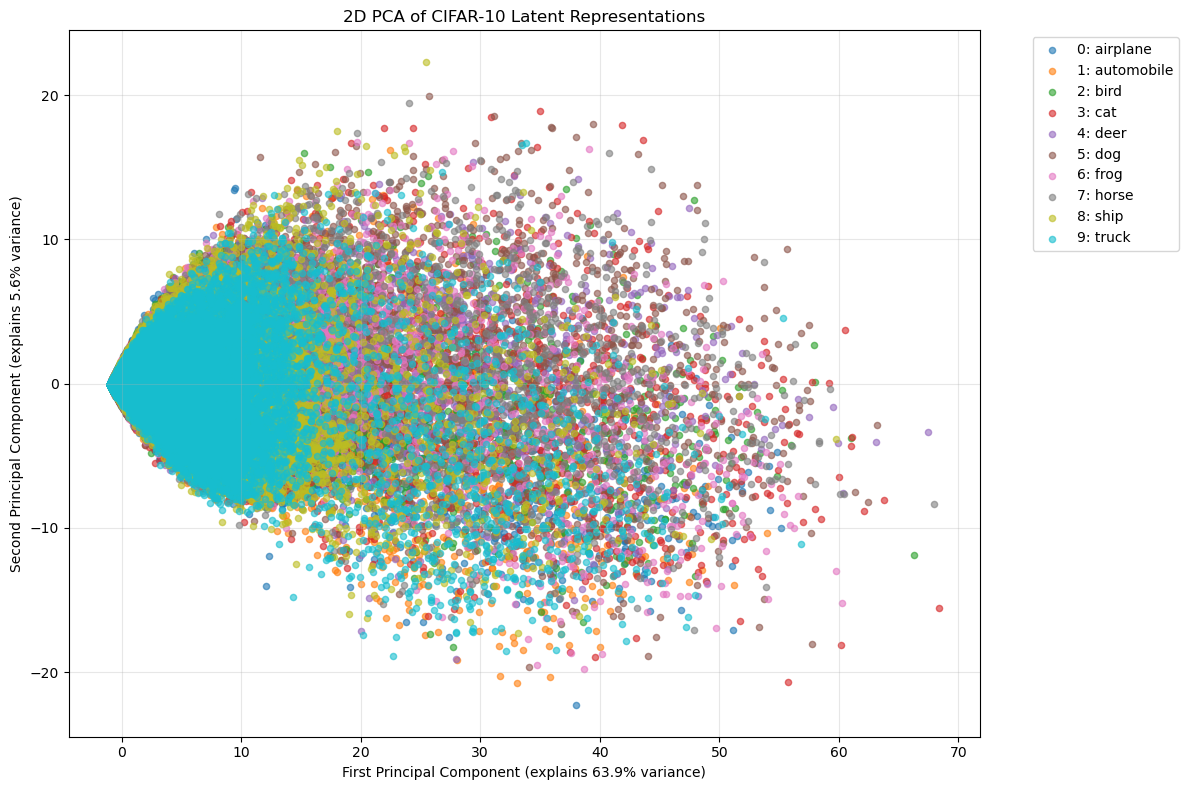

In [26]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# CIFAR-10 class names for better labeling
cifar10_classes = {
    0: 'airplane',
    1: 'automobile', 
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

def visualize_latent_pca(clean_latents_dict):
    """
    Perform 2D PCA on latent representations and create visualization
    
    Args:
        clean_latents_dict: Dictionary where keys are class labels (0-9) 
                           and values are lists of latent tensors
    """
    
    # Prepare data for PCA
    all_latents = []
    all_labels = []
    
    for class_label, latent_list in clean_latents_dict.items():
        for latent_tensor in latent_list:
            # Convert tensor to numpy and flatten if needed
            if isinstance(latent_tensor, torch.Tensor):
                latent_np = latent_tensor.detach().cpu().numpy()
            else:
                latent_np = latent_tensor
            
            # Flatten the latent vector (keeping batch dimension if present)
            if latent_np.ndim > 1:
                latent_flat = latent_np.reshape(latent_np.shape[0], -1)
                all_latents.extend(latent_flat)
                all_labels.extend([class_label] * latent_flat.shape[0])
            else:
                all_latents.append(latent_np.flatten())
                all_labels.append(class_label)
    
    # Convert to numpy arrays
    X = np.array(all_latents)
    y = np.array(all_labels)
    
    print(f"Data shape for PCA: {X.shape}")
    print(f"Number of samples per class:")
    unique, counts = np.unique(y, return_counts=True)
    for class_id, count in zip(unique, counts):
        print(f"  Class {class_id} ({cifar10_classes[class_id]}): {count} samples")
    
    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    print(f"\nPCA Results:")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Create the visualization
    plt.figure(figsize=(12, 8))
    
    # Use a colormap with distinct colors
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    # Plot each class with different colors
    for class_id in range(10):
        mask = y == class_id
        if np.any(mask):
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                       c=[colors[class_id]], 
                       label=f'{class_id}: {cifar10_classes[class_id]}',
                       alpha=0.6, s=20)
    
    plt.xlabel(f'First Principal Component (explains {pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'Second Principal Component (explains {pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('2D PCA of CIFAR-10 Latent Representations')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return pca, X_pca, y

# Example usage with your data:
pca_model, pca_data, labels = visualize_latent_pca(clean_latents_dict)
plt.show()

In [213]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def analyze_latent_halves(clean_latents_dict):
    """Analyze similarity within first and second halves of latent tensors for each class"""
    
    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                       'dog', 'frog', 'horse', 'ship', 'truck']
    
    for class_id, latent_list in clean_latents_dict.items():
        print(f"\nClass {class_id} ({cifar10_classes[class_id]}):")
        
        # Extract first and second halves
        first_halves = []
        second_halves = []
        
        for tensor in latent_list:
            # print(tensor.shape)
            if isinstance(tensor, torch.Tensor):
                tensor = tensor.detach().cpu().numpy()
            
            # Split along the correct dimension BEFORE flattening
            first_half = tensor[:64] 
            second_half = tensor[64:] 
            # print(second_half.shape)
            
            # Now flatten each half
            first_flat = first_half.reshape(first_half.shape[0], -1) if first_half.ndim > 1 else first_half.reshape(1, -1)
            second_flat = second_half.reshape(second_half.shape[0], -1) if second_half.ndim > 1 else second_half.reshape(1, -1)
            
            for f, s in zip(first_flat, second_flat):
                first_halves.append(f)
                second_halves.append(s)
        
        first_halves = np.array(first_halves)
        second_halves = np.array(second_halves)
        
        # Calculate cosine similarities
        first_sim = cosine_similarity(first_halves)
        second_sim = cosine_similarity(second_halves)
        
        # Get upper triangle (exclude diagonal)
        mask = np.triu(np.ones_like(first_sim, dtype=bool), k=1)
        first_similarities = first_sim[mask]
        second_similarities = second_sim[mask]
        
        print(f"  First half  - Mean: {first_similarities.mean():.3f}, Std: {first_similarities.std():.3f}")
        print(f"  Second half - Mean: {second_similarities.mean():.3f}, Std: {second_similarities.std():.3f}")
        print(f"  Samples: {len(first_halves)}")

# Usage:
analyze_latent_halves(clean_latents_dict)


Class 3 (cat):
  First half  - Mean: 0.036, Std: 0.123
  Second half - Mean: 0.001, Std: 0.020
  Samples: 960

Class 8 (ship):
  First half  - Mean: 0.032, Std: 0.114
  Second half - Mean: 0.001, Std: 0.020
  Samples: 1088

Class 0 (airplane):
  First half  - Mean: 0.033, Std: 0.117
  Second half - Mean: 0.001, Std: 0.018
  Samples: 832

Class 6 (frog):
  First half  - Mean: 0.037, Std: 0.130
  Second half - Mean: 0.001, Std: 0.019
  Samples: 1216

Class 1 (automobile):
  First half  - Mean: 0.032, Std: 0.111
  Second half - Mean: 0.001, Std: 0.018
  Samples: 640

Class 9 (truck):
  First half  - Mean: 0.034, Std: 0.114
  Second half - Mean: 0.001, Std: 0.019
  Samples: 704

Class 5 (dog):
  First half  - Mean: 0.034, Std: 0.122
  Second half - Mean: 0.001, Std: 0.019
  Samples: 576

Class 7 (horse):
  First half  - Mean: 0.036, Std: 0.122
  Second half - Mean: 0.001, Std: 0.020
  Samples: 832

Class 4 (deer):
  First half  - Mean: 0.033, Std: 0.121
  Second half - Mean: 0.001, Std: 0

In [81]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_tensor_heatmap(tensor, figsize=(16, 8)):
    """
    Plot heatmap of a 4D tensor with shape [1, channels, height, width]
    First 64 channels in orange, second 64 channels in blue, 0 values are white.
    
    Args:
        tensor: PyTorch tensor of shape [1, 128, 8, 8]
        figsize: Figure size tuple
    """
    # Remove batch dimension and convert to numpy
    data = tensor.squeeze(0).detach().cpu().numpy()  # Shape: [128, 8, 8]
    
    # Calculate grid dimensions (8x16 for 128 channels)
    n_channels = data.shape[0]
    cols = 16
    rows = 8
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    # Find global max for consistent color scale
    vmax = data.max()
    
    # Create custom colormaps (white at 0, colored at max)
    from matplotlib.colors import LinearSegmentedColormap
    
    # Orange colormap: white -> dark orange
    orange_cmap = LinearSegmentedColormap.from_list('orange', ['white', 'darkorange'])
    
    # Blue colormap: white -> navy blue  
    blue_cmap = LinearSegmentedColormap.from_list('blue', ['white', 'navy'])
    
    # Plot each channel
    for i in range(n_channels):
        if i < 64:
            # First 64 channels in orange
            cmap = orange_cmap
            title_color = 'darkorange'
        else:
            # Second 64 channels in blue
            cmap = blue_cmap
            title_color = 'darkblue'
            
        im = axes[i].imshow(data[i], cmap=cmap, vmin=0, vmax=vmax)
        axes[i].set_title(f'{i}', fontsize=6, color=title_color)
        axes[i].axis('off')
    
    plt.tight_layout(pad=0.5)
    plt.show()


In [28]:
def show_adv_examples(adv_images):
    # Show first 4 examples (or less if batch is smaller)
    num_to_show = min(4, adv_images.shape[0])
    
    fig, axes = plt.subplots(1, num_to_show, figsize=(12, 3))
    if num_to_show == 1:
        axes = [axes]
    
    for i in range(num_to_show):
        # Convert from (C, H, W) to (H, W, C) and move to CPU
        img = adv_images[i].permute(1, 2, 0).cpu().detach()
        
        # Clip values to [0, 1] range for display
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Adv Example {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

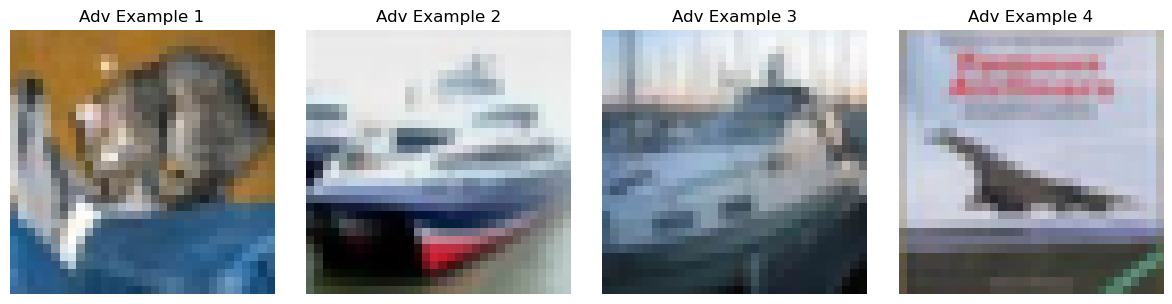

tensor([0, 0, 0, 0, 0], device='mps:0')
Attack success rate: 100.00%
5


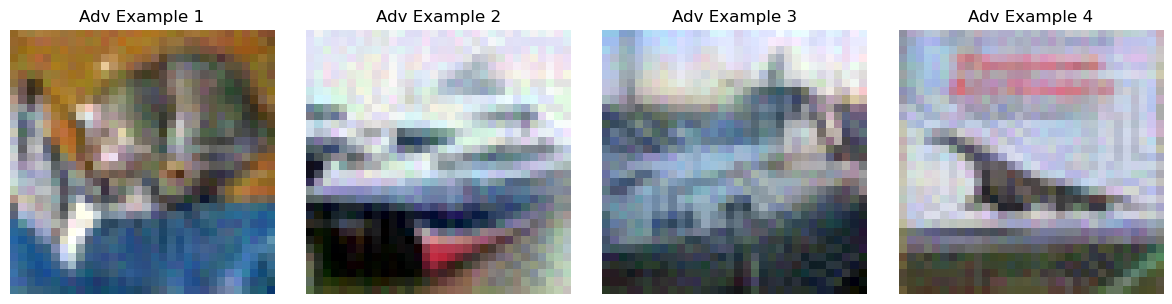

In [73]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=12/255, alpha=2/255, steps=40)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1, kappa=0, steps=50)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)


adv_images = []
imgs = []

# Use your normal data loader (with whatever preprocessing your model expects)
for images, labels in testloader:
    # print(images.shape); break
    images, labels = images.to(device)[:5], labels.to(device)[:5]
    show_adv_examples(images)
    
    # Generate adversarial examples
    target_labels = torch.zeros_like(labels)
    adv_images = pgd(images, target_labels)
    imgs = images.clone()
    
    # Evaluate
    with torch.no_grad():
        outputs = model(adv_images.to(device))
        # print(outputs.device)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        # print(predicted.device)
        
    success_rate = (predicted == target_labels).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')
    print(len(labels))
    break

show_adv_examples(adv_images)

In [103]:
outs_adv, latent_tensor_adv = model(adv_images[3:4], return_routed_act=True)

In [104]:
outs_clean, latent_tensor_clean = model(imgs[3:4], return_routed_act=True)

In [105]:
torch.argmax(outs_adv), torch.argmax(outs_clean)

(tensor(0, device='mps:0'), tensor(0, device='mps:0'))

In [106]:
latent_tensor_adv.shape

torch.Size([1, 128, 8, 8])

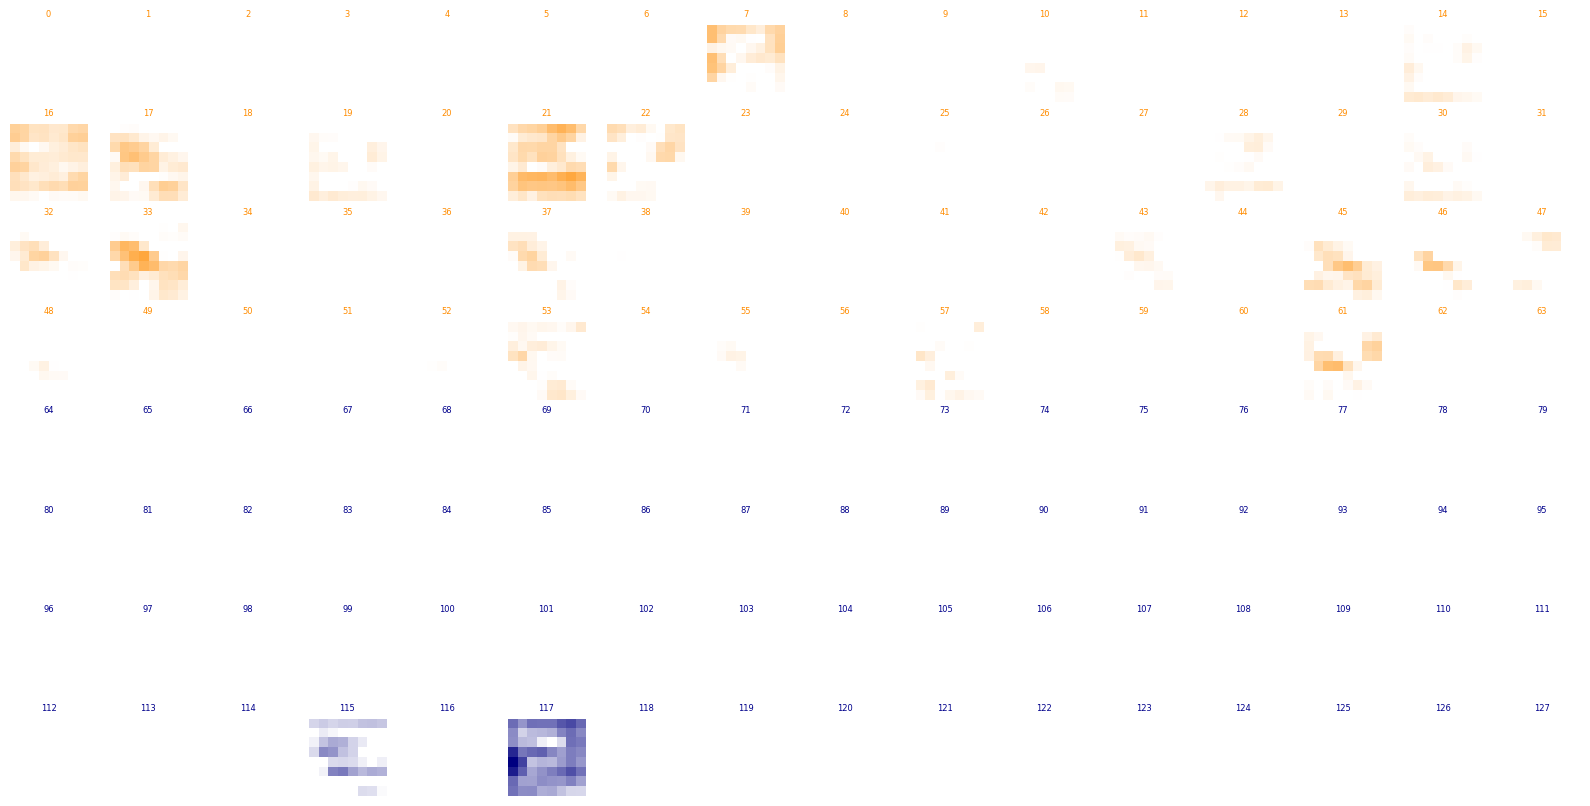

In [107]:
# Example usage:
plot_tensor_heatmap(latent_tensor_adv)

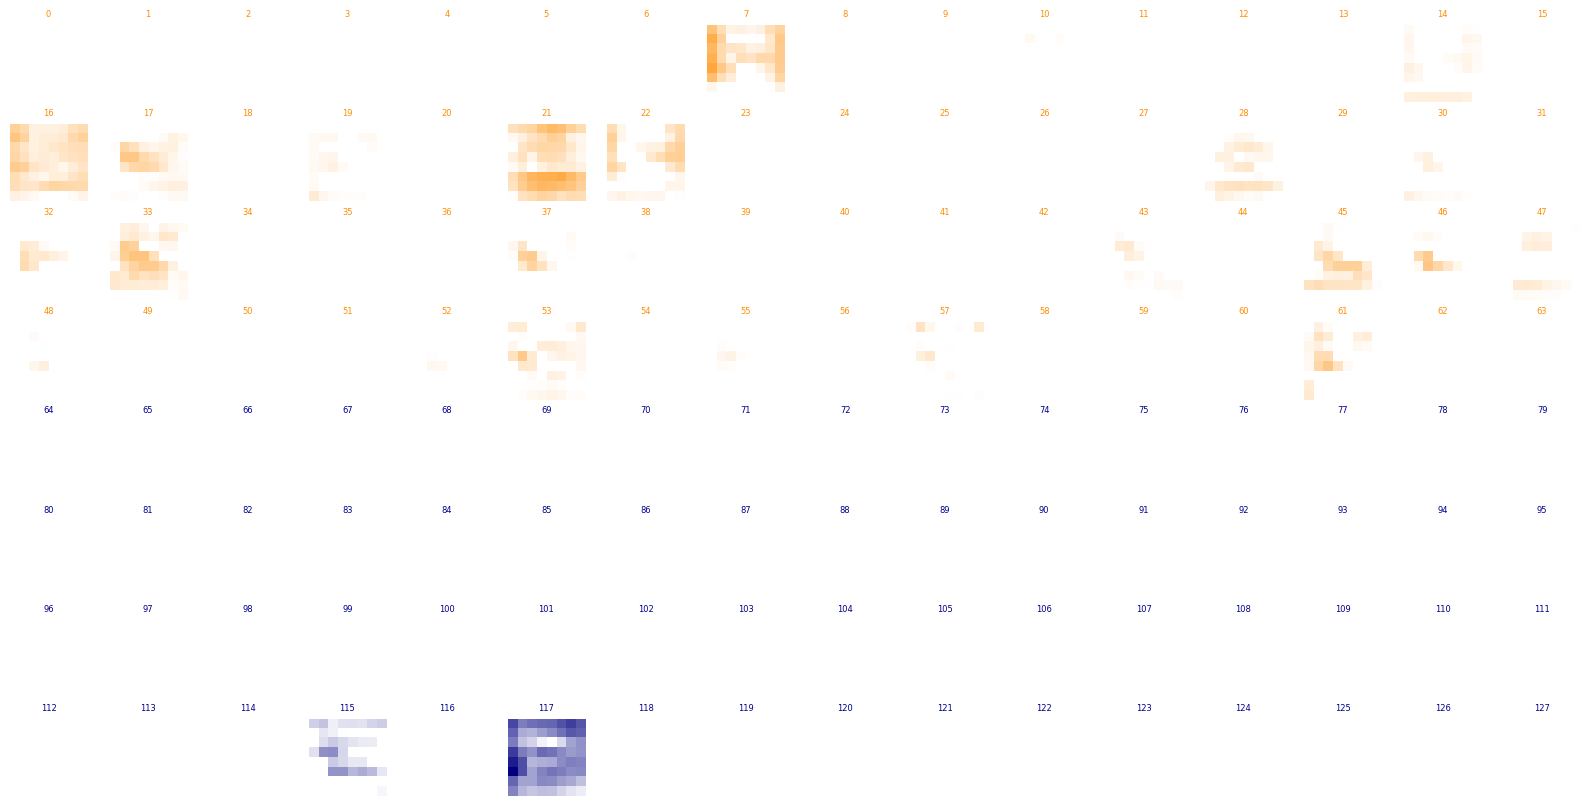

In [108]:
plot_tensor_heatmap(latent_tensor_clean)

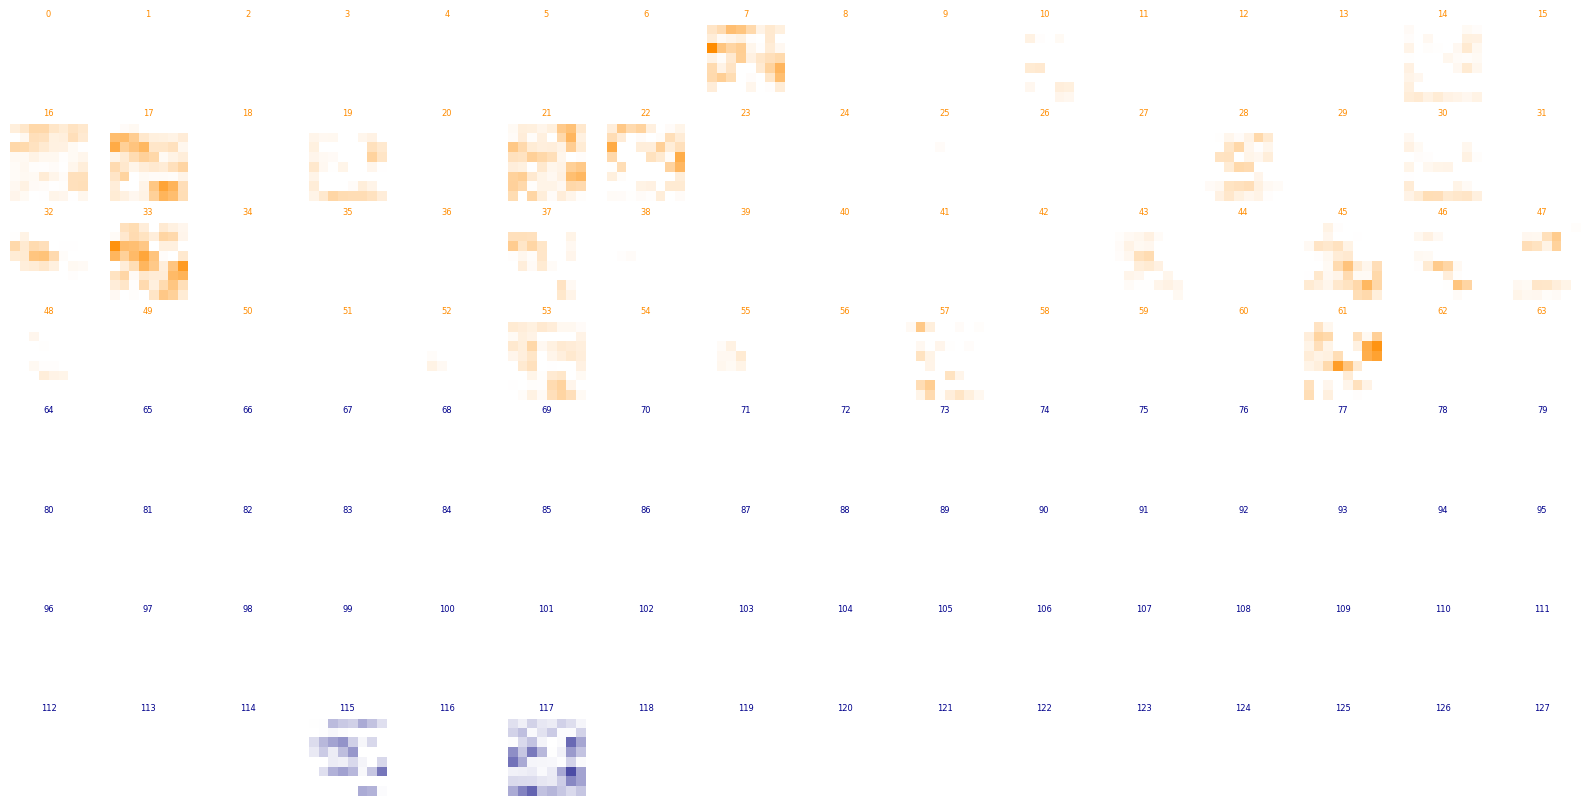

In [109]:
plot_tensor_heatmap(torch.abs(latent_tensor_clean - latent_tensor_adv))

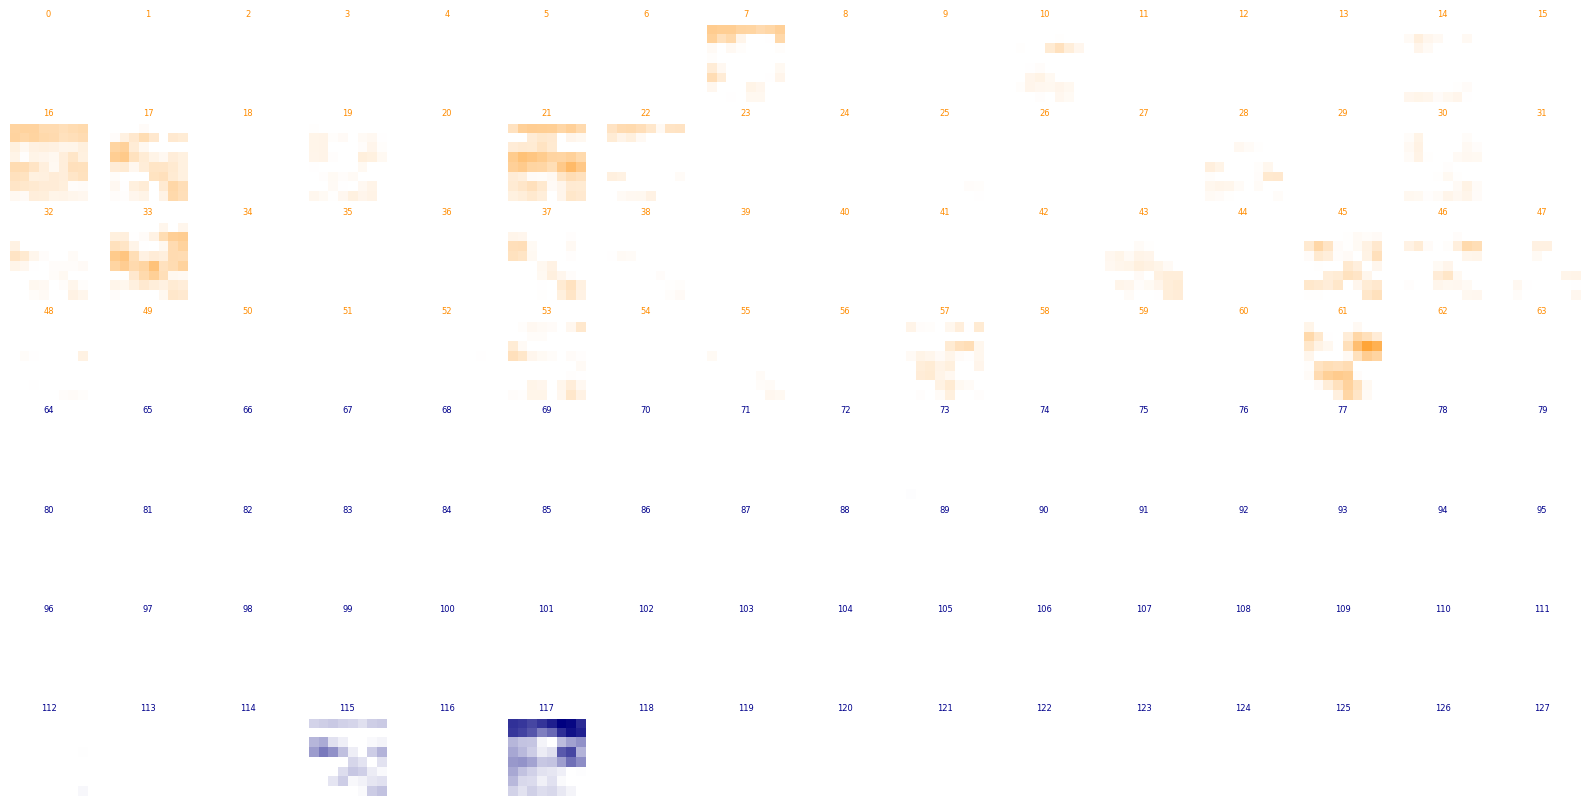

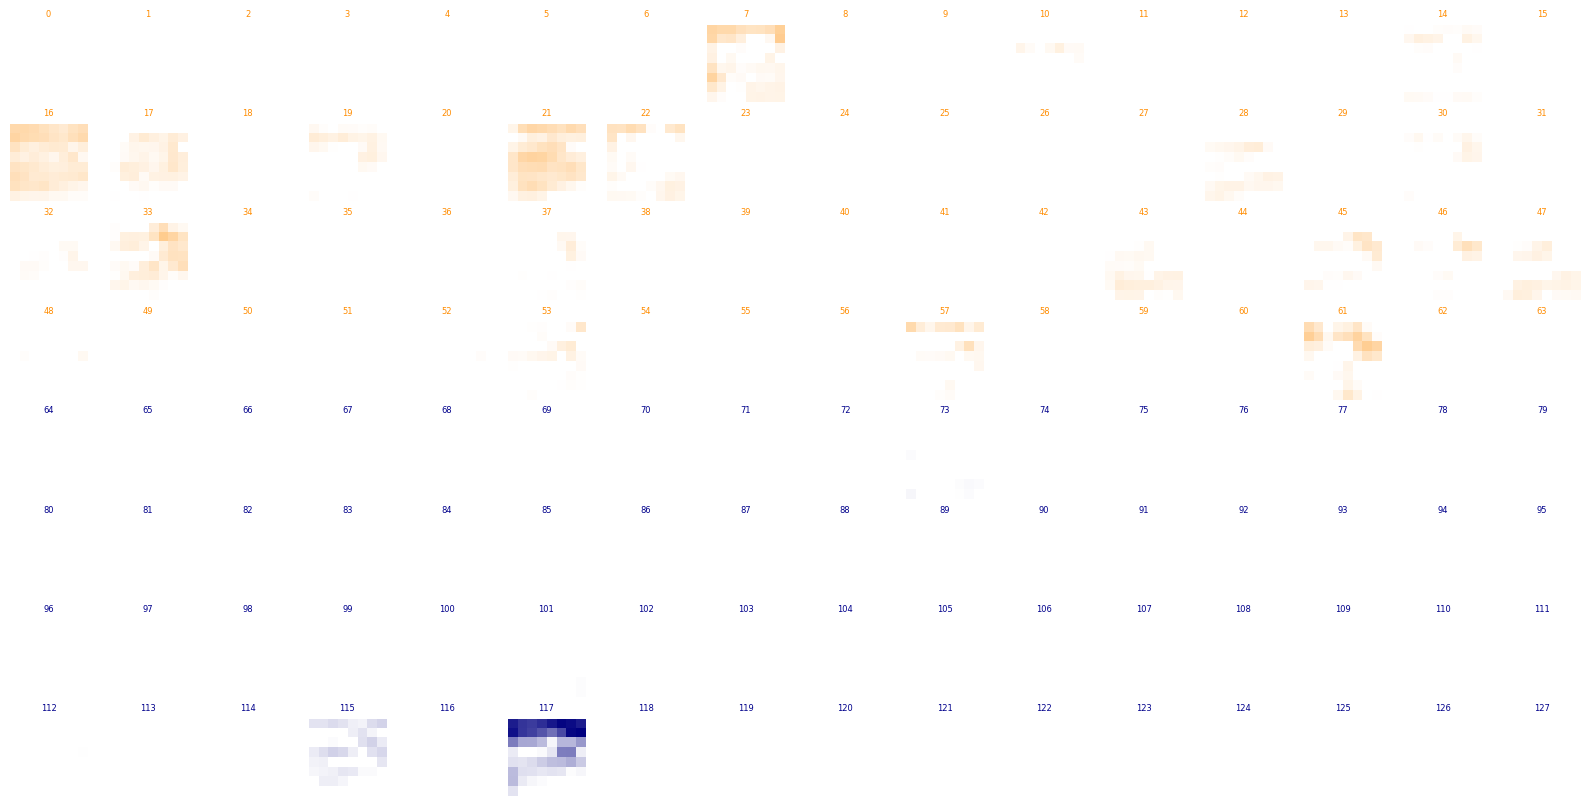

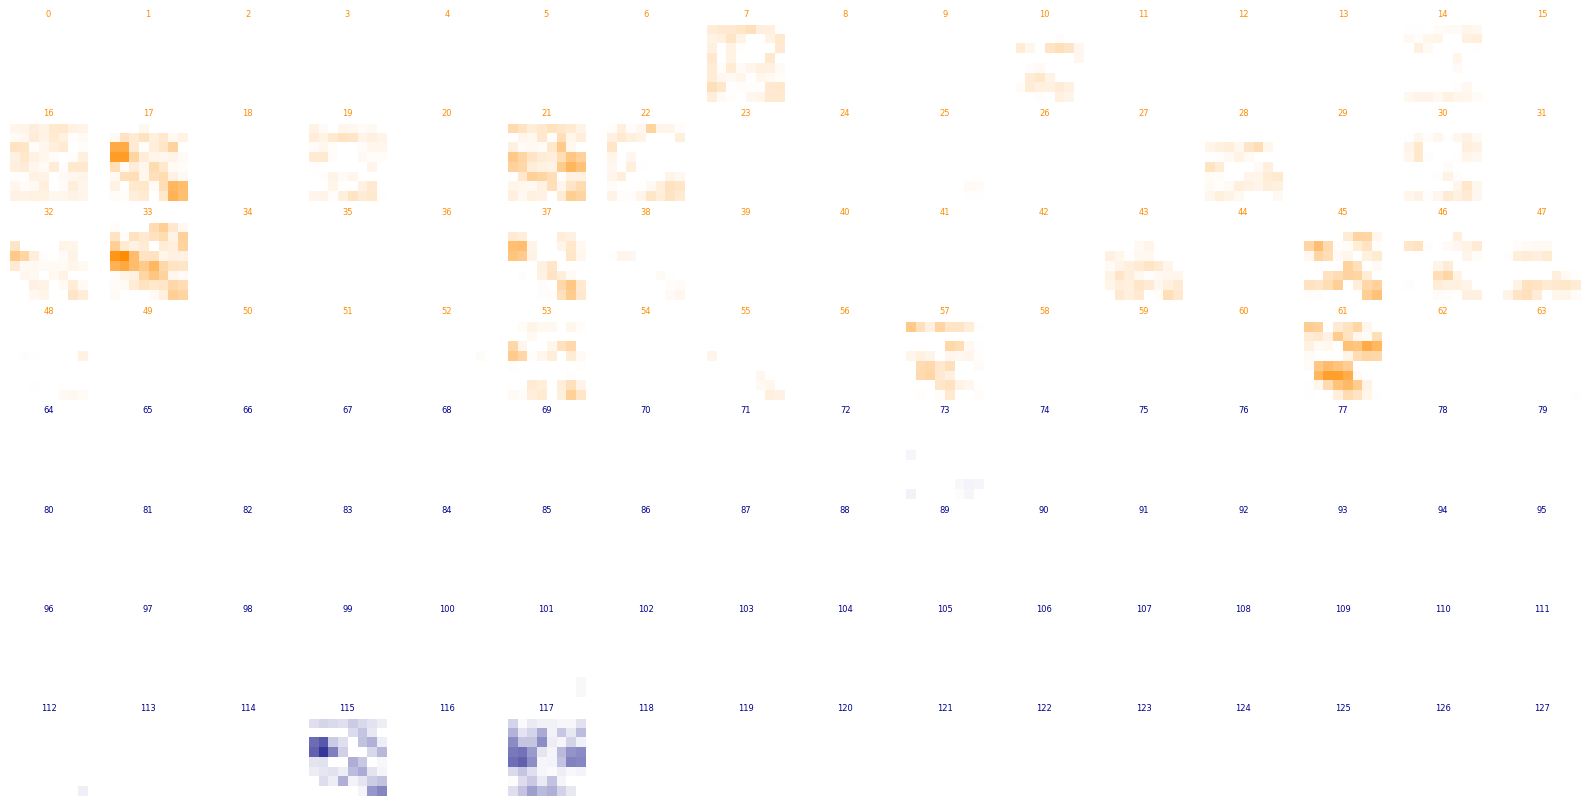

In [111]:
outs_adv, latent_tensor_adv = model(adv_images[2:3], return_routed_act=True)
outs_clean, latent_tensor_clean = model(imgs[2:3], return_routed_act=True)
plot_tensor_heatmap(latent_tensor_adv)
plot_tensor_heatmap(latent_tensor_clean)
plot_tensor_heatmap(torch.abs(latent_tensor_clean - latent_tensor_adv))

In [60]:
torch.argmax(outs_adv), torch.argmax(outs_clean)

(tensor(0, device='mps:0'), tensor(5, device='mps:0'))